<center> <h1> Evaluation of Models <h1/> <center/>

## Description

This notebooks contains the code for generating the entire analysis for chapter 7 of the thesis "Master Thesis: Enhanced Index Tracking with Distributionally Robust Optimization".

## Dependencies

Official modules downloaded with "pip install ..".

In [1]:
import sys
import os
import re
import glob
import datetime as dt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mosek.fusion import *
from tqdm import tqdm
import time
import scipy.stats as sps
import seaborn as sns
from scipy.stats import norm

Custom modules that can be found in the Git repository.

In [2]:
from EITP.Models.Model1 import IndexTracker as firstModel;
from EITP.Models.Model1DRO import IndexTracker as firstModelDRO;
from EITP.PerformanceEvaluation.QuantitativeStatistics import PerformanceMetrics;

## Controller

In [3]:
simType = "OoS";
GMS_data = "UD"

## Load In-Sample Data for Estimating Weights with Models

We start by loading the data to find the appropriate weights. The corresponding out-of-sample data set has been used to generate the scenarios in the next section.

In [4]:
# Load raw training data (in returns)
trainingData = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/IS-GMS-{}.csv".format(GMS_data), header=None);

# In-sample data is in returns
indexTrainingData = trainingData.iloc[:,0].values
assetsTrainingData = trainingData.iloc[:,1:].values

## Load Scenarios for Out-of-Sample Evaluation

Loading scenarios.

In [5]:
path = "./Scenarios/{}"
scenarios_OoS_GMS_UD = pd.read_csv(path.format("OoS-GMS-{}.csv".format(GMS_data)), index_col=False);

## Optimize Weights with Models

In [6]:
# Enhanced returns
alphaAnnualy = 0.0510;
alphaWeekly = (1 + alphaAnnualy)**(1/52) - 1;

# Specify Wasserstein-Radius
lowerEps = 10**(-16);
upperEps = 10**(-0.5);
epsCollection = np.linspace(lowerEps, upperEps, 5);

# Model parameters
beta = 0.95
gamma = 0.6
shortingCapacity = 0.00

Prepare out-of-sample tests with actual data supplied from article.

In [7]:
# Load data
outSample = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/OoS-GMS-{}.csv".format(GMS_data), header=None);

# Out-of-sample data is in levels
IndexOoS = outSample.pct_change();
IndexOoS = IndexOoS.values[:,0]
IndexOoS = IndexOoS[1:];
AssetsOoS = outSample.pct_change();
AssetsOoS = AssetsOoS.values[:,1:]
AssetsOoS = AssetsOoS[1:];

### 1. Base Model

In [8]:
# Train Base Model
M1 = firstModel(returnsAssets=assetsTrainingData, returnsIndex=indexTrainingData, betas=[beta], gammas=[gamma], shortingCapacity=shortingCapacity, alphaAnnualy=alphaAnnualy);
resultsM1 = M1.solve();

100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 17.48it/s]


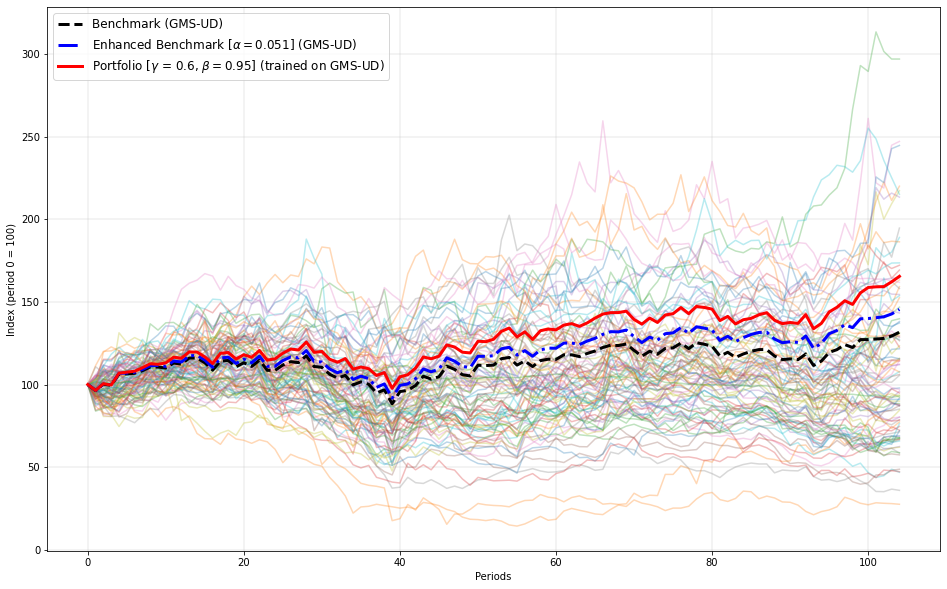

In [9]:
# Show in-sample performance visually
assetsM1_IS, indexM1_IS, enhancedIndexM1_IS, portfolioM1_IS = M1.IS(saveFile="Base_IS_{}".format(GMS_data), dataName="GMS-{}".format(GMS_data), plot=True);

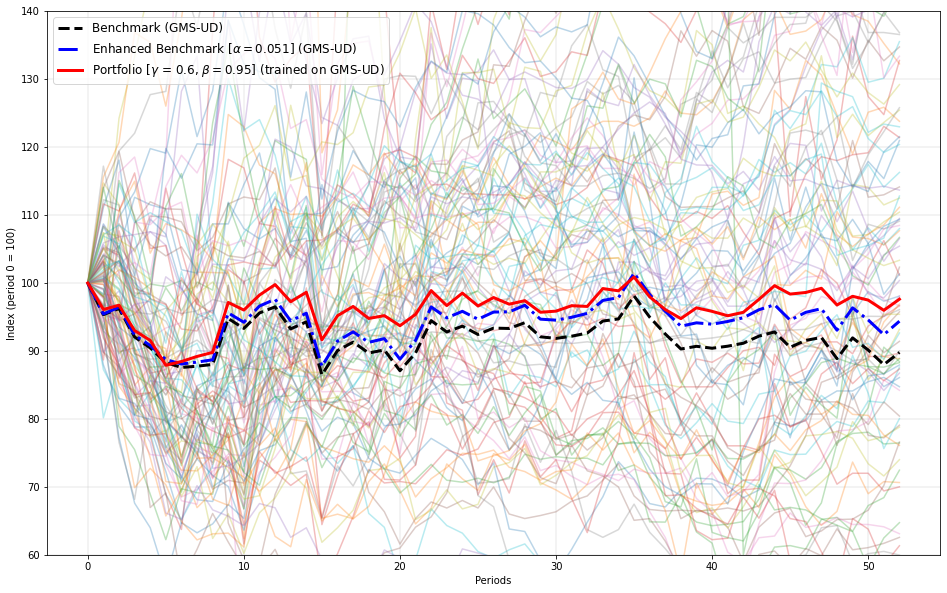

In [10]:
# Show out-of-sample performance visually
assetsM1_OoS, indexM1_OoS, enhancedIndexM1_OoS, portfolioM1_OoS = M1.OoS(AssetsOoS, IndexOoS, saveFile="Base_OoS_{}".format(GMS_data), dataName="GMS-{}".format(GMS_data), plot=True, ylim=[60,140]);

### 2. Base Model with DRO Extension

In [11]:
# Train Base Model with DRO
M1DRO = firstModelDRO(returnsAssets=assetsTrainingData, returnsIndex=indexTrainingData, betas=[beta], gammas=[gamma], shortingCapacity=shortingCapacity, alphaAnnualy=alphaAnnualy);
resultsM1RO = M1DRO.solve(epsCollection=epsCollection);

100%|███████████████████████████████████████████████| 5/5 [00:00<00:00, 35.41it/s]


In [12]:
M1DRO.setOptimalPortfolio(resultsM1RO, 1)

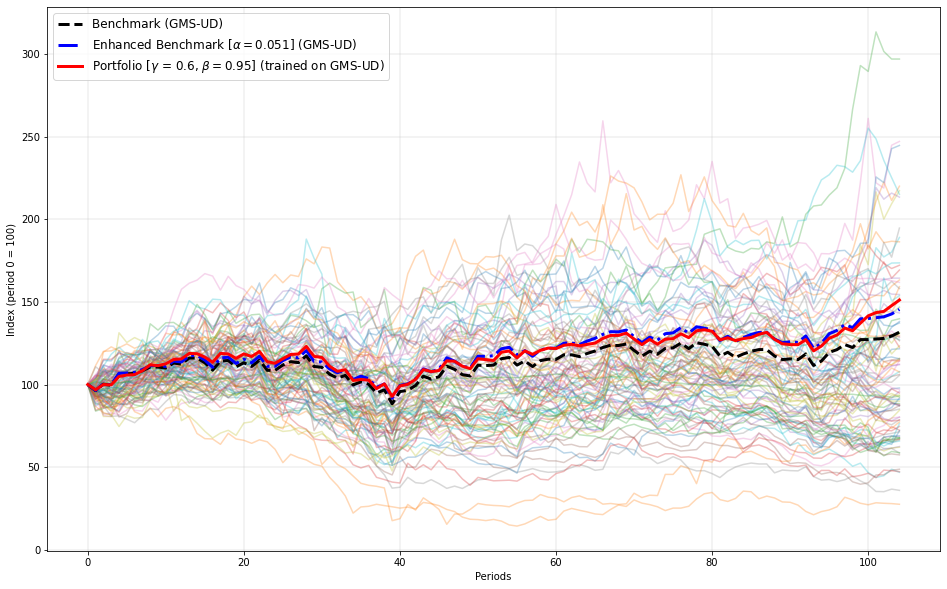

In [13]:
# Show in-sample performance visually
assetsM1DRO_IS, indexM1DRO_IS, enhancedIndexM1DRO_IS, portfolioM1DRO_IS = M1DRO.IS(saveFile="BaseDRO_IS_{}".format(GMS_data), dataName="GMS-{}".format(GMS_data), plot=True);

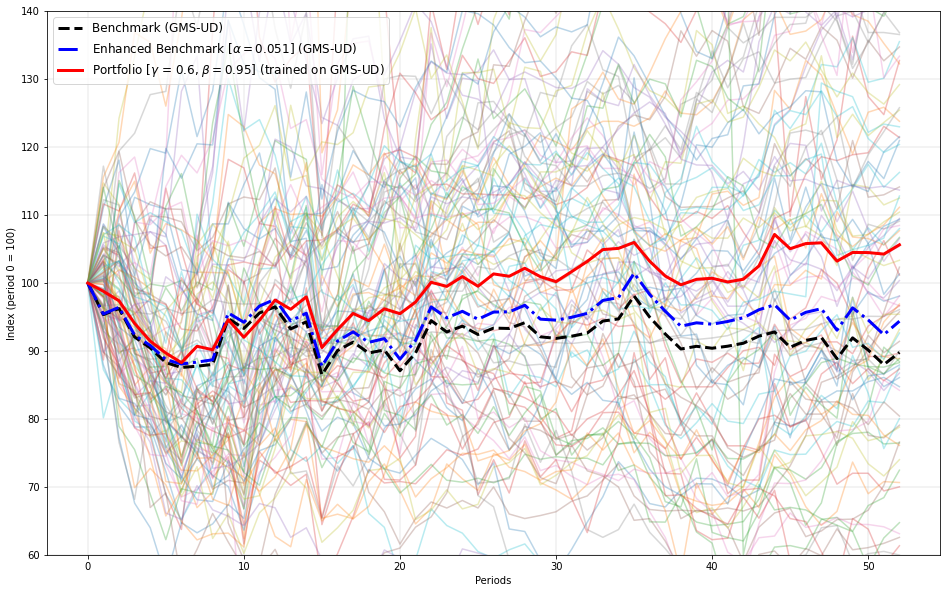

In [14]:
# Show out-of-sample performance visually
assetsM1DRO_OoS, indexM1DRO_OoS, enhancedIndexM1DRO_OoS, portfolioM1DRO_OoS = M1DRO.OoS(AssetsOoS, IndexOoS, saveFile="BaseDRO_OoS_".format(GMS_data), dataName="GMS-{}".format(GMS_data), plot=True, ylim=[60,140]);

In [15]:
scenarioResults = PerformanceMetrics(portfolioM1DRO_OoS, assetsM1DRO_OoS, indexM1DRO_OoS, enhancedIndexM1DRO_OoS)
results = pd.DataFrame(scenarioResults.getMetrics())

In [16]:
results

,DownsideSemiStandardDeviation,RMSE,ExcessReturnAverage,ExcessReturn,SortinoIndex,BeatBenchmarkRatio,TotalReturn,AverageReturn,P5,P10,P90
0,2.374295,3.458967,10.835586,11.242452,0.000865,53.809172,5.620619,6.969881,-0.056044,-0.03934,0.044154


## Performance Evaluation on Scenarios

In [22]:
# Load data
scenarios = pd.read_csv('./Scenarios/{}-GMS-{}.csv'.format(simType, GMS_data));
scenarioIdentifiers = scenarios['Scenario'].unique()

# Get specific scenario
specificScenario = scenarios[scenarios['Scenario'] == scenarioIdentifiers[0]]

# Scenario returns
scenarioReturns = specificScenario.pct_change().dropna();

# Segment into assets and index
index = scenarioReturns.values[:,2]
assets = scenarioReturns.values[:,3:]

# Run the model on the scenario
assetsM1DRO_OoS, indexM1DRO_OoS, enhancedIndexM1DRO_OoS, portfolioM1DRO_OoS = M1DRO.OoS(assets, index, plot=False, ylim=[75,165]);

# Compute statistics
scenarioResults = PerformanceMetrics(portfolioM1DRO_OoS, assetsM1DRO_OoS, indexM1DRO_OoS, enhancedIndexM1DRO_OoS)

# Combine results
scenarioColumn = pd.DataFrame({'Scenario': [scenarioIdentifiers[0]]})
results = pd.DataFrame(scenarioResults.getMetrics())
frames = [scenarioColumn, results]
aggregateResults = pd.concat(frames, axis=1)

for scenario in scenarioIdentifiers[1:]:
    
    # Get specific scenario
    specificScenario = scenarios[scenarios['Scenario'] == scenario]

    # Scenario returns
    scenarioReturns = specificScenario.pct_change().dropna();

    # Segment into assets and index
    index = scenarioReturns.values[:,2]
    assets = scenarioReturns.values[:,3:]

    # Run the model on the scenario
    assetsM1DRO_OoS, indexM1DRO_OoS, enhancedIndexM1DRO_OoS, portfolioM1DRO_OoS = M1DRO.OoS(assets, index, plot=False, ylim=[75,165]);

    # Compute statistics
    scenarioResults = PerformanceMetrics(portfolioM1DRO_OoS, assetsM1DRO_OoS, indexM1DRO_OoS, enhancedIndexM1DRO_OoS)

    # Combine results
    scenarioColumn = pd.DataFrame({'Scenario': [scenario]})
    results = pd.DataFrame(scenarioResults.getMetrics())
    frames1 = [scenarioColumn, results]
    rowResults = pd.concat(frames1, axis=1)
    frames2 = [aggregateResults, rowResults]
    aggregateResults = pd.concat(frames2, axis=0)

### 1. Distributions of Performance Statistics

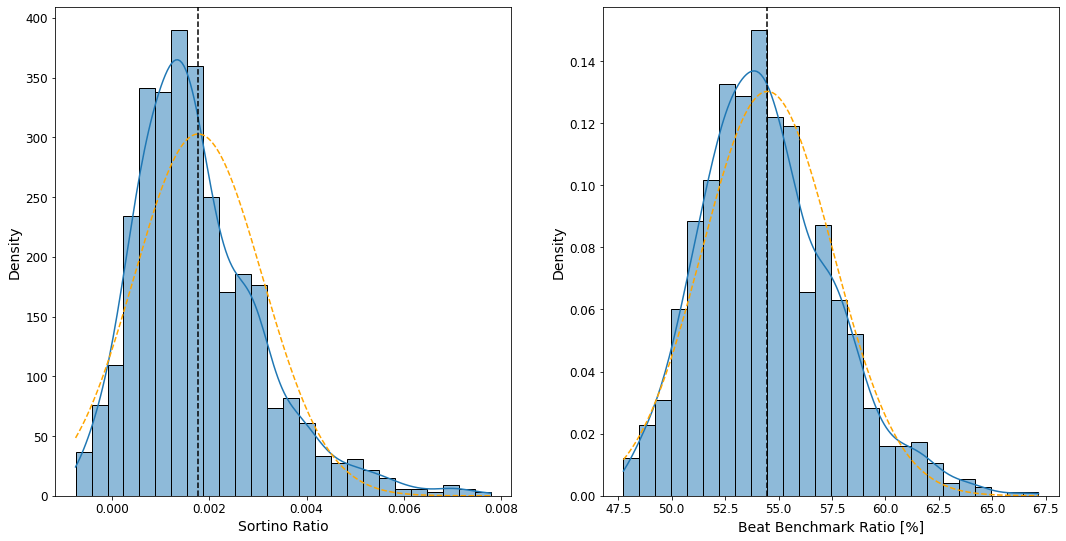

In [23]:
# Structure estimates
allEstimatesBBR = aggregateResults['BeatBenchmarkRatio'].values
allEstimatesSR = aggregateResults['SortinoIndex'].values

# Calculate estimates: BBR and SR
estimateBBR = aggregateResults['BeatBenchmarkRatio'].mean()
stdBBR = aggregateResults['BeatBenchmarkRatio'].std()
estimateSR = aggregateResults['SortinoIndex'].mean()
stdSR = aggregateResults['SortinoIndex'].std()

# Ranges of estimates
rangeBBR = np.linspace(min(aggregateResults['BeatBenchmarkRatio'].values),max(aggregateResults['BeatBenchmarkRatio'].values),1000)
rangeSR = np.linspace(min(aggregateResults['SortinoIndex'].values),max(aggregateResults['SortinoIndex'].values),1000)

# Plot figure
fig, ax = plt.subplots(1, 2, figsize=(18,9))
sns.histplot(allEstimatesSR, kde=True, ax=ax[0], stat = "density")
ax[0].set_xlabel('Sortino Ratio', fontsize = 14)
ax[0].set_ylabel('Density', fontsize = 14)
ax[0].tick_params(axis="both", labelsize=12)
ax[0].axvline(x = estimateSR, ymin = 0, ymax = 1, color="black", linestyle="--")
ax[0].plot(rangeSR, norm.pdf(rangeSR, loc=estimateSR, scale=stdSR), color="orange", linestyle="--")
sns.histplot(allEstimatesBBR, kde=True, ax=ax[1], stat = "density")
ax[1].set_xlabel('Beat Benchmark Ratio [%]', fontsize = 14)
ax[1].set_ylabel('Density', fontsize = 14)
ax[1].tick_params(axis="both", labelsize=12)
ax[1].axvline(x = estimateBBR, ymin = 0, ymax = 1, color="black", linestyle="--")
ax[1].plot(rangeBBR, norm.pdf(rangeBBR, loc=estimateBBR, scale=stdBBR), color="orange", linestyle="--")
plt.show()

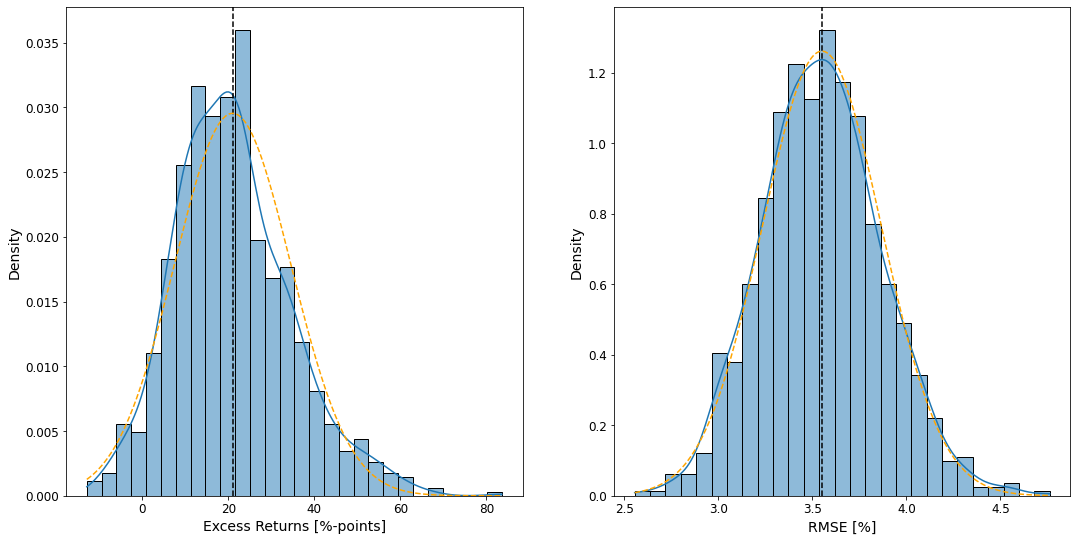

In [24]:
# Structure estimates
allEstimatesBBR = aggregateResults['RMSE'].values
allEstimatesSR = aggregateResults['ExcessReturn'].values

# Calculate estimates: BBR and SR
estimateBBR = aggregateResults['RMSE'].mean()
stdBBR = aggregateResults['RMSE'].std()
estimateSR = aggregateResults['ExcessReturn'].mean()
stdSR = aggregateResults['ExcessReturn'].std()

# Ranges of estimates
rangeBBR = np.linspace(min(allEstimatesBBR),max(allEstimatesBBR),1000)
rangeSR = np.linspace(min(allEstimatesSR),max(allEstimatesSR),1000)

# Plot figure
fig, ax = plt.subplots(1, 2, figsize=(18,9))
sns.histplot(allEstimatesSR, kde=True, ax=ax[0], stat = "density")
ax[0].set_xlabel('Excess Returns [%-points]', fontsize = 14)
ax[0].set_ylabel('Density', fontsize = 14)
ax[0].tick_params(axis="both", labelsize=12)
ax[0].axvline(x = estimateSR, ymin = 0, ymax = 1, color="black", linestyle="--")
ax[0].plot(rangeSR, norm.pdf(rangeSR, loc=estimateSR, scale=stdSR), color="orange", linestyle="--")
sns.histplot(allEstimatesBBR, kde=True, ax=ax[1], stat = "density")
ax[1].set_xlabel('RMSE [%]', fontsize = 14)
ax[1].set_ylabel('Density', fontsize = 14)
ax[1].tick_params(axis="both", labelsize=12)
ax[1].axvline(x = estimateBBR, ymin = 0, ymax = 1, color="black", linestyle="--")
ax[1].plot(rangeBBR, norm.pdf(rangeBBR, loc=estimateBBR, scale=stdBBR), color="orange", linestyle="--")
plt.show()

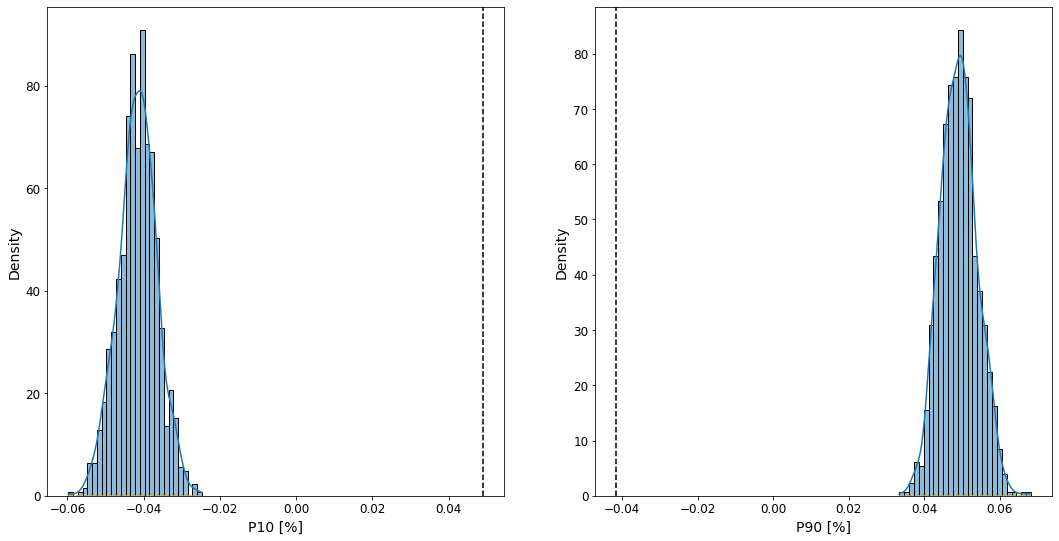

In [25]:
# Structure estimates
allEstimatesSR = aggregateResults['P10'].values
allEstimatesBBR = aggregateResults['P90'].values

# Calculate estimates: BBR and SR
estimateSR = aggregateResults['P90'].mean()
stdSR = aggregateResults['P90'].std()
estimateBBR = aggregateResults['P10'].mean()
stdBBR = aggregateResults['P10'].std()

# Ranges of estimates
rangeBBR = np.linspace(min(allEstimatesBBR),max(allEstimatesBBR),1000)
rangeSR = np.linspace(min(allEstimatesSR),max(allEstimatesSR),1000)

# Plot figure
fig, ax = plt.subplots(1, 2, figsize=(18,9))
sns.histplot(allEstimatesSR, kde=True, ax=ax[0], stat = "density")
ax[0].set_xlabel('P10 [%]', fontsize = 14)
ax[0].set_ylabel('Density', fontsize = 14)
ax[0].tick_params(axis="both", labelsize=12)
ax[0].axvline(x = estimateSR, ymin = 0, ymax = 1, color="black", linestyle="--")
ax[0].plot(rangeSR, norm.pdf(rangeSR, loc=estimateSR, scale=stdSR), color="orange", linestyle="--")
sns.histplot(allEstimatesBBR, kde=True, ax=ax[1], stat = "density")
ax[1].set_xlabel('P90 [%]', fontsize = 14)
ax[1].set_ylabel('Density', fontsize = 14)
ax[1].tick_params(axis="both", labelsize=12)
ax[1].axvline(x = estimateBBR, ymin = 0, ymax = 1, color="black", linestyle="--")
ax[1].plot(rangeBBR, norm.pdf(rangeBBR, loc=estimateBBR, scale=stdBBR), color="orange", linestyle="--")
plt.show()

It is probably more appropriate to use a joint histogram.

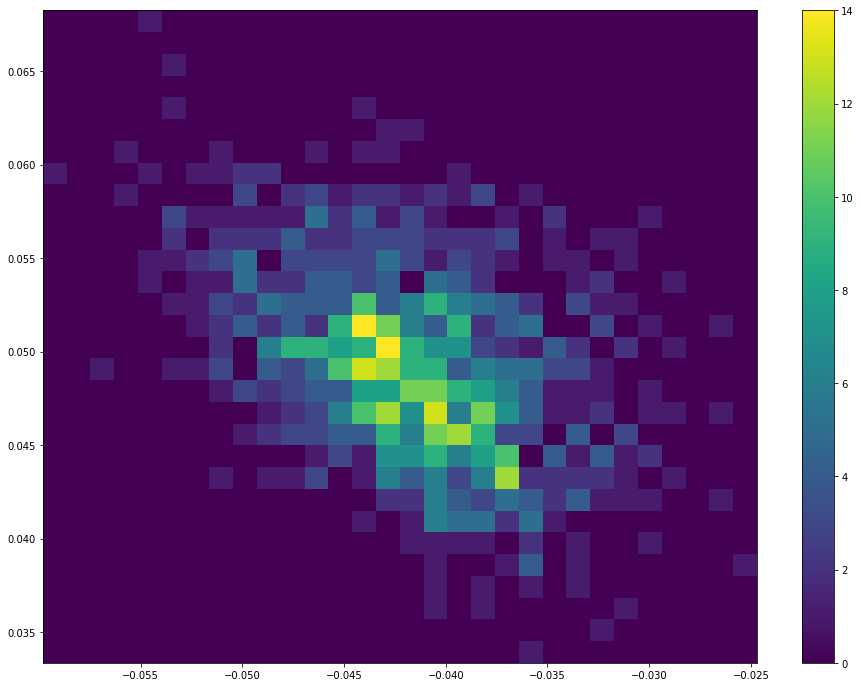

In [26]:
fig, ax = plt.subplots(figsize=(16,12))
h = ax.hist2d(allEstimatesSR, allEstimatesBBR, bins = 30)
fig.colorbar(h[3], ax=ax)
plt.show()